In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import math
import re
import numpy as np
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import plotly.express as px

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

### Download Dataset

In [ ]:
# https://api.acleddata.com/acled/read?key={api_key}&email={email}



base_url = 'https://api.acleddata.com/acled/read'

params = {
    'key': api_key,
    'email': email,
    'start_date': '2020-01-01',
    'end_date': '2024-11-16'
}

response = requests.get(base_url, params=params)

if response.status_code == 200:
    data = response.json()
    if isinstance(data, list):
        print(f"Number of records: {len(data)}")
    elif "data" in data:  
        print(f"Number of records: {len(data['data'])}")
    else:
        print("Unknown JSON structure.")
else:
    print(f"Error: {response.status_code}")

records_raw = data["data"]
records = pd.DataFrame(records_raw)
print(records.shape)
print(records.columns)
print(records["year"].unique())

records.to_csv("acled_data.csv", index=False)
records.head()

In [4]:
more_records = pd.read_csv("/Users/anoutsala/Documents/datathon_2024/2018-01-01-2024-11-16.csv", sep=';')

In [5]:
more_records.head(2)

event_id_cnty        event_date  year  time_precision  \
0      BFO12795  08 November 2024  2024               1   
1      BFO12802  08 November 2024  2024               1   

            disorder_type                  event_type sub_event_type  \
0      Political violence  Violence against civilians         Attack   
1  Strategic developments      Strategic developments          Other   

                                         actor1 assoc_actor_1  inter1  ...  \
0  JNIM: Group for Support of Islam and Muslims           NaN       2  ...   
1  JNIM: Group for Support of Islam and Muslims           NaN       2  ...   

    location latitude  longitude  geo_precision                        source  \
0       Bane  11.5756    -0.3566              1                      Facebook   
1  Silmangue  13.8886    -0.6095              1  Facebook; Undisclosed Source   

          source_scale                                              notes  \
0            New media  On 8 November 2024, JNIM militants attacked th...   
1  Local partner-Other  Other: On 8 November 2024, JNIM militants cond...   

  fatalities tags   timestamp  
0          2  NaN  1731368104  
1          0  NaN  1731368104  

[2 rows x 31 columns]

### Data Cleaning

In [6]:
# date time format
more_records['event_date'] = pd.to_datetime(more_records['event_date'], format='%d %B %Y')
more_records['month'] = more_records['event_date'].dt.month
more_records['day'] = more_records['event_date'].dt.day
# rearrange columns
event_date_idx = more_records.columns.get_loc('event_date')
more_records.insert(event_date_idx + 1, 'month', more_records.pop('month'))
more_records.insert(event_date_idx + 2, 'day', more_records.pop('day'))

more_records['civilian_targeting'] = more_records['civilian_targeting'].apply(
    lambda x: 1 if x == "Civilian targeting" else 0
)

print(f"Columns: {more_records.columns}")
print(f"Years of data: {more_records['year'].unique()}")

Columns: Index(['event_id_cnty', 'event_date', 'month', 'day', 'year', 'time_precision',
       'disorder_type', 'event_type', 'sub_event_type', 'actor1',
       'assoc_actor_1', 'inter1', 'actor2', 'assoc_actor_2', 'inter2',
       'interaction', 'civilian_targeting', 'iso', 'region', 'country',
       'admin1', 'admin2', 'admin3', 'location', 'latitude', 'longitude',
       'geo_precision', 'source', 'source_scale', 'notes', 'fatalities',
       'tags', 'timestamp'],
      dtype='object')
Years of data: [2024 2023 2022 2021 2020 2019 2018]


In [7]:
more_records.shape

(1964808, 33)

In [8]:
more_records.isna().sum()

event_id_cnty               0
event_date                  0
month                       0
day                         0
year                        0
time_precision              0
disorder_type               0
event_type                  0
sub_event_type              0
actor1                      0
assoc_actor_1         1170997
inter1                      0
actor2                1062989
assoc_actor_2         1733804
inter2                      0
interaction                 0
civilian_targeting          0
iso                         0
region                      0
country                     0
admin1                    740
admin2                  56988
admin3                1022391
location                    0
latitude                    0
longitude                   0
geo_precision               0
source                      0
source_scale                0
notes                       0
fatalities                  0
tags                   996111
timestamp                   0
dtype: int

In [9]:
# select relevant columns
lst = ["event_date", "month", "year", "event_type", "sub_event_type", "actor1", "inter1", "inter2", "interaction", "civilian_targeting", "region", "country", "location", "latitude", "longitude", "source_scale", "fatalities"]
records = more_records[lst]
records['year_month'] = pd.to_datetime(records['event_date']).dt.to_period('M')
records.head()

/var/folders/s_/yf9hp5d54l9bjwvwpjcwbk200000gn/T/ipykernel_99622/427234649.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  records['year_month'] = pd.to_datetime(records['event_date']).dt.to_period('M')


event_date  month  year                  event_type    sub_event_type  \
0 2024-11-08     11  2024  Violence against civilians            Attack   
1 2024-11-08     11  2024      Strategic developments             Other   
2 2024-11-08     11  2024                     Battles       Armed clash   
3 2024-11-08     11  2024                       Riots      Mob violence   
4 2024-11-08     11  2024                    Protests  Peaceful protest   

                                         actor1  inter1  inter2  interaction  \
0  JNIM: Group for Support of Islam and Muslims       2       7           27   
1  JNIM: Group for Support of Islam and Muslims       2       1           12   
2  JNIM: Group for Support of Islam and Muslims       2       4           24   
3                             Rioters (Bolivia)       5       7           57   
4                          Protesters (Bolivia)       6       0           60   

   civilian_targeting          region       country   location  latitude  \
0                   1  Western Africa  Burkina Faso       Bane   11.5756   
1                   0  Western Africa  Burkina Faso  Silmangue   13.8886   
2                   0  Western Africa  Burkina Faso   Gorgadji   14.0329   
3                   1   South America       Bolivia     La Paz  -16.4957   
4                   0   South America       Bolivia     La Paz  -16.4957   

   longitude          source_scale  fatalities year_month  
0    -0.3566             New media           2    2024-11  
1    -0.6095   Local partner-Other           0    2024-11  
2    -0.5197   Local partner-Other           0    2024-11  
3   -68.1336  Subnational-National           0    2024-11  
4   -68.1336              National           0    2024-11

In [36]:
records.to_csv("records.csv", index=False)

### Exploratory Data Analysis

In [12]:
fatalities_per_sub_event_type = records.groupby('sub_event_type')['fatalities'].mean().reset_index()
fatalities_per_sub_event_type = fatalities_per_sub_event_type.sort_values(by='fatalities', ascending=False)
fatalities_per_sub_event_type.head(15)

sub_event_type  fatalities
23                         Suicide bomb    9.753510
7                       Chemical weapon    7.600000
10         Government regains territory    4.404232
15  Non-state actor overtakes territory    3.544012
3                           Armed clash    2.048862
2                      Air/drone strike    1.461703
5                                Attack    1.327450
20        Remote explosive/landmine/IED    1.180092
21                      Sexual violence    0.822454
9    Excessive force against protesters    0.714286
22    Shelling/artillery/missile attack    0.347137
11                              Grenade    0.283601
14                         Mob violence    0.220174
8                 Disrupted weapons use    0.108782
24                Violent demonstration    0.105724

In [13]:
civilian_targeting_per_sub_event_type = records.groupby('sub_event_type')['civilian_targeting'].mean().reset_index()
civilian_targeting_per_sub_event_type = civilian_targeting_per_sub_event_type.sort_values(by='civilian_targeting', ascending=False)
civilian_targeting_per_sub_event_type.head(15)

sub_event_type  civilian_targeting
0       Abduction/forced disappearance            1.000000
5                               Attack            1.000000
21                     Sexual violence            1.000000
9   Excessive force against protesters            1.000000
7                      Chemical weapon            0.880000
14                        Mob violence            0.433492
23                        Suicide bomb            0.385335
20       Remote explosive/landmine/IED            0.312469
11                             Grenade            0.262971
2                     Air/drone strike            0.144009
22   Shelling/artillery/missile attack            0.086717
16   Non-violent transfer of territory            0.000000
19           Protest with intervention            0.000000
18                    Peaceful protest            0.000000
17                               Other            0.000000

In [14]:
fatalities_per_actor1 = records.groupby('actor1')['fatalities'].mean().reset_index()
fatalities_per_actor1 = fatalities_per_actor1.sort_values(by='fatalities', ascending=False)
fatalities_per_actor1.head(15)

actor1  fatalities
1542   Batende Ethnic Militia (Democratic Republic of...  107.200000
10292                     Samri Youth Militia (Ethiopia)   87.142857
6385   Military Forces of Cameroon (1982-) Joint Task...   70.000000
5072                   Kutigi Communal Militia (Nigeria)   43.000000
3275   Gaajok-Khor-Eastern Jikany Sub-Clan Militia (S...   43.000000
7290                     NTJ: National Thowheed Jama'ath   39.571429
1158           Athoi-Agar Sub-Clan Militia (South Sudan)   39.000000
5729        MPDF: Master People's Defense Force - Gangaw   38.000000
6064                     Maru Communal Militia (Nigeria)   38.000000
913                      Alliance Force of Chindwin Yoma   34.000000
10063  SADC: Southern African Development Community R...   32.500000
7670                Oku Iboku Communal Militia (Nigeria)   30.000000
867    Alawaka Column (People's Defense Force - Thato...   30.000000
3337                   Gassol Communal Militia (Nigeria)   30.000000
10609  Songyie Bambembele Communal Militia (Democrati...   30.000000

In [18]:
civilian_targeting_per_actor1 = records.groupby('actor1')['civilian_targeting'].mean().reset_index()
civilian_targeting_per_actor1 = civilian_targeting_per_actor1.sort_values(by='civilian_targeting', ascending=False)
civilian_targeting_per_actor1.head(15)

actor1  civilian_targeting
0                               100 Lane Gang                 1.0
9622         Qabno Communal Militia (Somalia)                 1.0
9724         Raiganj Communal Militia (India)                 1.0
9713       Raffour Communal Militia (Algeria)                 1.0
9709                      Rabu Allah Movement                 1.0
9696  RSP: Social Progressives Networks Party                 1.0
9695       RSP: Revolutionary Socialist Party                 1.0
9689                RPK: Roots Party of Kenya                 1.0
9655                                R-15 Gang                 1.0
9651      Quezaltecos Locos Salvatruchos Gang                 1.0
9644         Qemant Ethnic Militia (Ethiopia)                 1.0
9636   Qasim Khah Communal Militia (Pakistan)                 1.0
9623        Qabza Communal Militia (Pakistan)                 1.0
9604   Puzhithikulam Communal Militia (India)                 1.0
3447           Gouka Communal Militia (Benin)                 1.0

   Civilian Targeting  Average Fatalities
0                   0            0.491713
1                   1            1.202869


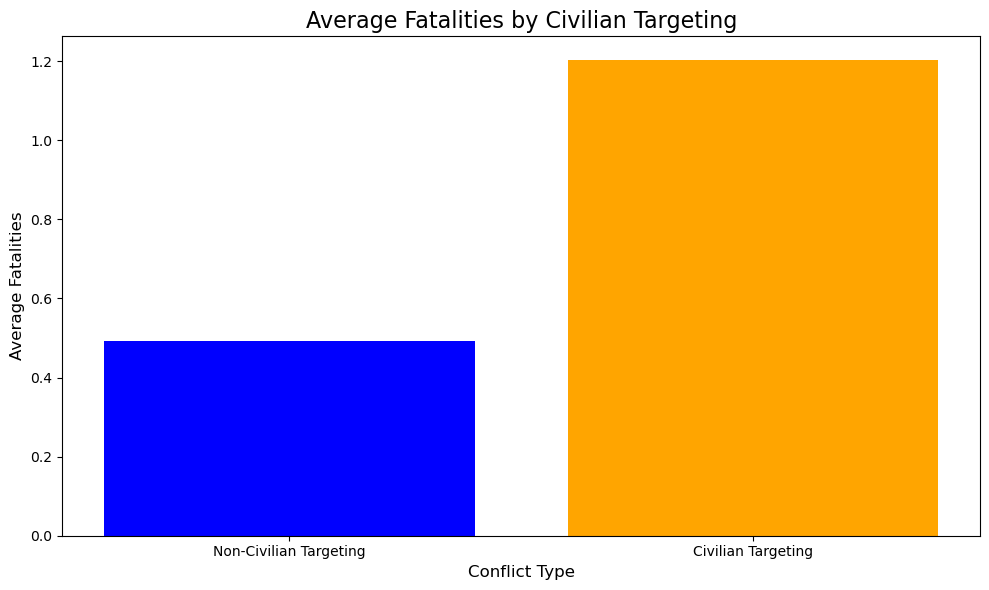

In [20]:
fatalities_comparison = records.groupby('civilian_targeting')['fatalities'].mean().reset_index()

fatalities_comparison.columns = ['Civilian Targeting', 'Average Fatalities']

print(fatalities_comparison)

plt.figure(figsize=(10, 6))
plt.bar(fatalities_comparison['Civilian Targeting'], fatalities_comparison['Average Fatalities'], color=['blue', 'orange'])
plt.title("Average Fatalities by Civilian Targeting", fontsize=16)
plt.ylabel("Average Fatalities", fontsize=12)
plt.xlabel("Conflict Type", fontsize=12)
plt.xticks([0, 1], ['Non-Civilian Targeting', 'Civilian Targeting'])
plt.tight_layout()
plt.show()

In [21]:
print(records['fatalities'].min(), records['fatalities'].max(), records['fatalities'].mean())

bins = [0, 1, 10, float('inf')]  
labels = ['0', '1-10', '10+']  

records['fatalities_binned'] = pd.cut(records['fatalities'], bins=bins, labels=labels, right=False)

binned_distribution = records['fatalities_binned'].value_counts().sort_index()
binned_distribution

0 1000 0.594469281476867


/var/folders/s_/yf9hp5d54l9bjwvwpjcwbk200000gn/T/ipykernel_99622/538989881.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  records['fatalities_binned'] = pd.cut(records['fatalities'], bins=bins, labels=labels, right=False)


fatalities_binned
0       1638892
1-10     295425
10+       30491
Name: count, dtype: int64

In [22]:
actors_with_fatalities = fatalities_per_actor1[fatalities_per_actor1['fatalities'] > 0]['actor1']

actor1_filtered_records = records[records['actor1'].isin(actors_with_fatalities)]
actor1_filtered_records.head()

event_date  month  year                  event_type    sub_event_type  \
0 2024-11-08     11  2024  Violence against civilians            Attack   
1 2024-11-08     11  2024      Strategic developments             Other   
2 2024-11-08     11  2024                     Battles       Armed clash   
3 2024-11-08     11  2024                       Riots      Mob violence   
4 2024-11-08     11  2024                    Protests  Peaceful protest   

                                         actor1  inter1  inter2  interaction  \
0  JNIM: Group for Support of Islam and Muslims       2       7           27   
1  JNIM: Group for Support of Islam and Muslims       2       1           12   
2  JNIM: Group for Support of Islam and Muslims       2       4           24   
3                             Rioters (Bolivia)       5       7           57   
4                          Protesters (Bolivia)       6       0           60   

   civilian_targeting          region       country   location  latitude  \
0                   1  Western Africa  Burkina Faso       Bane   11.5756   
1                   0  Western Africa  Burkina Faso  Silmangue   13.8886   
2                   0  Western Africa  Burkina Faso   Gorgadji   14.0329   
3                   1   South America       Bolivia     La Paz  -16.4957   
4                   0   South America       Bolivia     La Paz  -16.4957   

   longitude          source_scale  fatalities year_month fatalities_binned  
0    -0.3566             New media           2    2024-11              1-10  
1    -0.6095   Local partner-Other           0    2024-11                 0  
2    -0.5197   Local partner-Other           0    2024-11                 0  
3   -68.1336  Subnational-National           0    2024-11                 0  
4   -68.1336              National           0    2024-11                 0

### Modeling

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.84      0.91    412149
        1-10       0.62      0.74      0.68     88444
         10+       0.14      0.83      0.23      9123

    accuracy                           0.82    509716
   macro avg       0.58      0.80      0.60    509716
weighted avg       0.91      0.82      0.85    509716

Accuracy: 0.8189305417134247


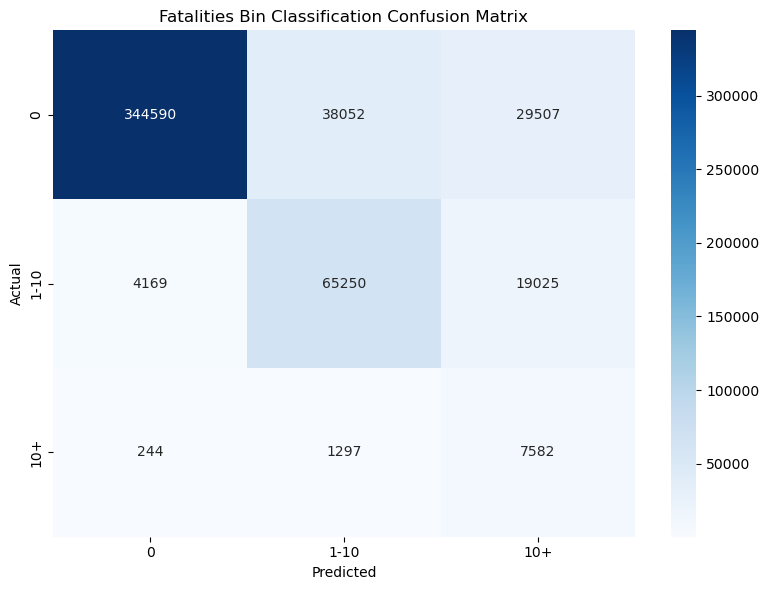

In [23]:
features = ['sub_event_type', 'actor1', 'civilian_targeting', 'interaction']
target = "fatalities_binned"


label_encoders = {}
records_encoded = actor1_filtered_records.copy()
for feature in features:
    le = LabelEncoder()
    records_encoded[feature] = le.fit_transform(records_encoded[feature].astype(str))
    label_encoders[feature] = le

X = records_encoded[features]
y = records_encoded[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_classifier = RandomForestClassifier(random_state=42, class_weight="balanced")
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {np.sum(y_test == y_pred) / len(y_test)}")

conf_matrix = confusion_matrix(y_test, y_pred, labels=y.cat.categories)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=y.cat.categories, yticklabels=y.cat.categories, cmap="Blues")
plt.title("Fatalities Bin Classification Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [24]:
### using Markov models to predict the next most likely actor per country

records_sorted = records.sort_values(by=['country', 'event_date'])

transition_counts = {}

for country, group in records_sorted.groupby("country"):
    actor_sequence = group['actor1'].tolist()  
    transitions = zip(actor_sequence[:-1], actor_sequence[1:])  
    transition_counts[country] = Counter(transitions)

next_actor_predictions = {}
for country, transitions in transition_counts.items():
    next_actor_predictions[country] = {}
    for (current_actor, next_actor), count in transitions.items():
        if current_actor not in next_actor_predictions[country]:
            next_actor_predictions[country][current_actor] = (next_actor, count)
        else:

            if count > next_actor_predictions[country][current_actor][1]:
                next_actor_predictions[country][current_actor] = (next_actor, count)

results = []
for country, actor_dict in next_actor_predictions.items():
    for current_actor, (next_actor, count) in actor_dict.items():
        results.append({'Country': country, 'Current Actor': current_actor, 'Next Most Likely Actor': next_actor, 'Count': count})

results_df = pd.DataFrame(results)

# Display the top results
results_df.sort_values(by=['Country', 'Count'], ascending=[True, False]).head(15)


Country                                      Current Actor  \
5   Afghanistan                                            Taliban   
6   Afghanistan         Military Forces of Afghanistan (2014-2021)   
1   Afghanistan             Unidentified Armed Group (Afghanistan)   
59  Afghanistan             Military Forces of Afghanistan (2021-)   
9   Afghanistan  Military Forces of Afghanistan (2014-2021) Spe...   
2   Afghanistan           NATO: North Atlantic Treaty Organization   
60  Afghanistan                          National Resistance Front   
0   Afghanistan                           Protesters (Afghanistan)   
11  Afghanistan             Islamic State Khorasan Province (ISKP)   
7   Afghanistan           Police Forces of Afghanistan (2014-2021)   
61  Afghanistan  Police Forces of Afghanistan (2021-) General D...   
14  Afghanistan  Police Forces of Afghanistan (2014-2021) Natio...   
15  Afghanistan                           Militia (Pro-Government)   
76  Afghanistan                          Afghanistan Freedom Front   
8   Afghanistan  Taliban and/or Islamic State Khorasan Province...   

                        Next Most Likely Actor  Count  
5                                      Taliban  20117  
6   Military Forces of Afghanistan (2014-2021)   8165  
1                                      Taliban   1083  
59      Military Forces of Afghanistan (2021-)    839  
9   Military Forces of Afghanistan (2014-2021)    421  
2                                      Taliban    359  
60      Military Forces of Afghanistan (2021-)    266  
0                     Protesters (Afghanistan)    216  
11      Islamic State Khorasan Province (ISKP)    200  
7   Military Forces of Afghanistan (2014-2021)    192  
61      Military Forces of Afghanistan (2021-)    134  
14                                     Taliban     90  
15                                     Taliban     87  
76      Military Forces of Afghanistan (2021-)     71  
8   Military Forces of Afghanistan (2014-2021)     47

In [25]:
transition_probabilities = {}
probability_results = []

for country, group in records_sorted.groupby("country"):
    actor_sequence = group['actor1'].tolist() 
    transitions = list(zip(actor_sequence[:-1], actor_sequence[1:])) 
    
    transition_counts = Counter(transitions)
    
    total_transitions = {}
    for (current_actor, next_actor), count in transition_counts.items():
        if current_actor not in total_transitions:
            total_transitions[current_actor] = 0
        total_transitions[current_actor] += count
    
    country_probabilities = {}
    for (current_actor, next_actor), count in transition_counts.items():
        if current_actor not in country_probabilities:
            country_probabilities[current_actor] = {}
        country_probabilities[current_actor][next_actor] = count / total_transitions[current_actor]
    
    for current_actor, next_actors in country_probabilities.items():
        for next_actor, probability in next_actors.items():
            transition_count = transition_counts.get((current_actor, next_actor), 0)
            probability_results.append({
                'Country': country,
                'Current Actor': current_actor,
                'Next Actor': next_actor,
                'Probability': probability,
                'Count': transition_count
            })

probability_df = pd.DataFrame(probability_results)

probability_df = probability_df.sort_values(by=['Country', 'Probability'], ascending=[True, False])
probability_df.iloc[51000:51020]

Country                                      Current Actor  \
51234  Russia                                          Supratsiu   
51235  Russia                                          Supratsiu   
51326  Russia                                             Oblava   
51327  Russia                                             Oblava   
51337  Russia  Military Forces of Russia (2000-) Territorial ...   
51123  Russia                       Government of Russia (2000-)   
51139  Russia   Military Forces of Russia (2000-) National Guard   
51344  Russia  Police Forces of Russia (2000-) State Emergenc...   
51088  Russia      Police Forces of Russia (2000-) Prison Guards   
51300  Russia                                              Atesh   
51150  Russia                   Private Security Forces (Russia)   
51319  Russia  Military Forces of Russia (2000-) Chechen Batt...   
51021  Russia                    Police Forces of Russia (2000-)   
51174  Russia   Military Forces of Russia (2000-) Special Forces   
51201  Russia                           Militia (Pro-Government)   
51350  Russia          Military Forces of Russia (2000-) Marines   
51046  Russia                  Military Forces of Russia (2000-)   
50945  Russia                  Unidentified Armed Group (Russia)   
51331  Russia  Military Forces of Ukraine (2019-) Main Direct...   
51293  Russia                                       Wagner Group   

                                         Next Actor  Probability  Count  
51234                                     Supratsiu     0.500000      1  
51235                           Protesters (Russia)     0.500000      1  
51326            Military Forces of Ukraine (2019-)     0.500000      1  
51327                           Protesters (Russia)     0.500000      1  
51337  Military Forces of Ukraine (2019-) Air Force     0.500000      2  
51123                           Protesters (Russia)     0.482353     41  
51139                           Protesters (Russia)     0.461538      6  
51344            Military Forces of Ukraine (2019-)     0.461538      6  
51088                           Protesters (Russia)     0.457447     43  
51300  Military Forces of Ukraine (2019-) Air Force     0.454545      5  
51150                           Protesters (Russia)     0.428571      3  
51319            Military Forces of Ukraine (2019-)     0.428571      3  
51021                           Protesters (Russia)     0.406250    273  
51174                           Protesters (Russia)     0.400000      2  
51201                           Protesters (Russia)     0.400000      2  
51350             Military Forces of Russia (2000-)     0.400000      6  
51046             Military Forces of Russia (2000-)     0.340000    833  
50945                           Protesters (Russia)     0.338061    286  
51331             Military Forces of Russia (2000-)     0.333333      4  
51293            Military Forces of Ukraine (2019-)     0.315789      6

In [26]:
subevent_frequencies = records.groupby(['actor1', 'sub_event_type']).size().reset_index(name='Frequency')

total_frequencies = subevent_frequencies.groupby('actor1')['Frequency'].sum().reset_index(name='Total_Frequency')

subevent_frequencies = subevent_frequencies.merge(total_frequencies, on='actor1')

subevent_frequencies['Probability'] = subevent_frequencies['Frequency'] / subevent_frequencies['Total_Frequency']

most_likely_actions = subevent_frequencies.sort_values(
    by=['actor1', 'Probability'], ascending=[True, False]
).groupby('actor1').head(1)

most_likely_actions[["actor1", "sub_event_type", "Probability"]].iloc[200:215]

actor1  \
437  ARMLP: Arab Resistance Movement to Liberate Pa...   
440               ARSA: Arakan Rohingya Salvation Army   
443               ARSC: Anyar Region Strategic Command   
446  ASALA: Armenian Secret Army for the Liberation...   
447      ASEAN: Association of Southeast Asian Nations   
448                           ASF: Alpha Special Force   
450                                ASF: Aung San Force   
455                                    ASG: Abu Sayyaf   
462                    ASG: Aung San Generation Monywa   
468         ASL: Bangladesh Awami Swechchasebak League   
470  ASPAC: Ahoada Security Planning Advisory Commi...   
474                    AST-MDY: Aung Si Taw - Mandalay   
475                 ASTF: Anonymous Special Task Force   
478                       ASWJ: Ahle Sunnat Wal Jamaat   
480                         ASWJ: Ahlu Sunna Wal Jamaa   

                    sub_event_type  Probability  
437       Change to group/activity     1.000000  
440                         Attack     0.493671  
443               Air/drone strike     0.333333  
446   Looting/property destruction     1.000000  
447                          Other     1.000000  
448  Remote explosive/landmine/IED     1.000000  
450                    Armed clash     0.647059  
455                    Armed clash     0.795652  
462                    Armed clash     0.250000  
468                         Attack     0.750000  
470                         Attack     1.000000  
474  Remote explosive/landmine/IED     0.450000  
475               Air/drone strike     0.500000  
478                    Armed clash     0.500000  
480                    Armed clash     0.437500

In [27]:
civilian_targeting_probs = records.groupby('actor1')['civilian_targeting'].mean().reset_index(name='Civilian_Targeting_Prob')

civilian_targeting_probs['Civilian_Targeting_Flag'] = (civilian_targeting_probs['Civilian_Targeting_Prob'] > 0).astype(int)

interaction_frequencies = records.groupby(['actor1', 'interaction']).size().reset_index(name='Frequency')
interaction_frequencies = interaction_frequencies.sort_values(
    by=['actor1', 'Frequency'], ascending=[True, False]
).groupby('actor1').head(1)  

actor_analysis = civilian_targeting_probs.merge(
    interaction_frequencies[['actor1', 'interaction']], on='actor1', how='left'
)

actor_analysis.head(15)

actor1  Civilian_Targeting_Prob  \
0                          100 Lane Gang                    1.000   
1                        100 Rounds Gang                    0.500   
2                101 Battalion (Tajoura)                    0.000   
3                       103 Zombies Gang                    0.625   
4                            11 + 1 Gang                    1.000   
5                  111th Brigade (Libya)                    0.000   
6                          112th Brigade                    1.000   
7                          116th Brigade                    0.000   
8   11BRF: 11 Brothers Revolution Forces                    0.000   
9                        128th Battalion                    0.000   
10                      13rd Street Gang                    1.000   
11                         166th Brigade                    0.000   
12                     18 March Division                    0.000   
13                  1st Coastal Division                    0.000   
14                 1st Infantry Division                    0.000   

    Civilian_Targeting_Flag  interaction  
0                         1           37  
1                         1           33  
2                         0           13  
3                         1           37  
4                         1           37  
5                         0           33  
6                         1           27  
7                         0           33  
8                         0           13  
9                         0           33  
10                        1           37  
11                        0           30  
12                        0           12  
13                        0           12  
14                        0           22

/opt/anaconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


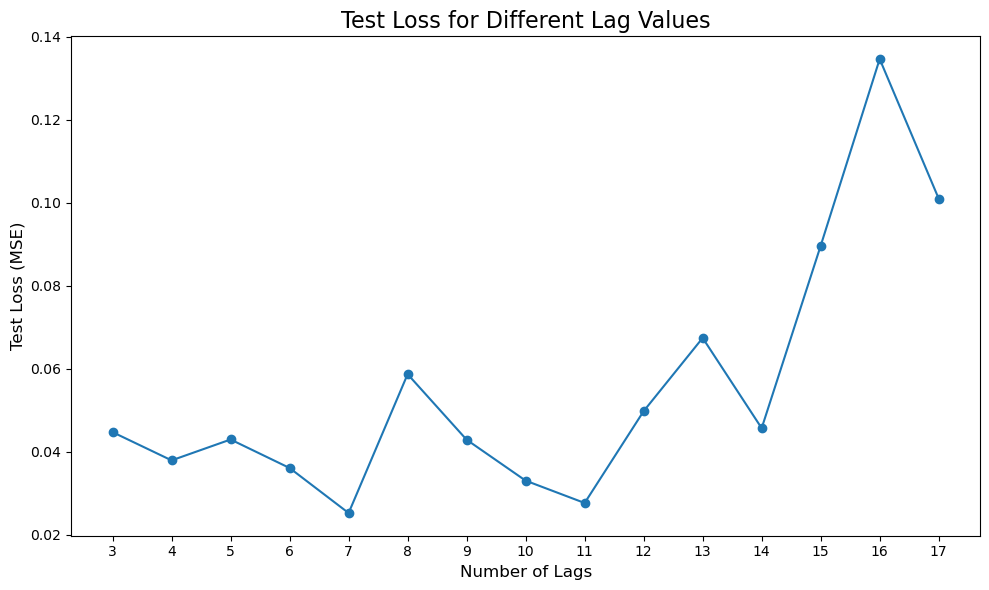

Best Lag Value: 7 with Loss: 0.025202264077961445
Epoch 20/300, Loss: 0.033263541758060455
Epoch 40/300, Loss: 0.009009328670799732
Epoch 60/300, Loss: 0.006289991550147533
Epoch 80/300, Loss: 0.004153495654463768
Epoch 100/300, Loss: 0.0019432009430602193
Epoch 120/300, Loss: 0.0014100861735641956
Epoch 140/300, Loss: 0.001187724992632866
Epoch 160/300, Loss: 0.0009620303753763437
Epoch 180/300, Loss: 0.0019016372971236706
Epoch 200/300, Loss: 0.0006921975291334093
Epoch 220/300, Loss: 0.00036415172507986426
Epoch 240/300, Loss: 0.016827205196022987
Epoch 260/300, Loss: 0.000558685336727649
Epoch 280/300, Loss: 0.0010804838966578245
Epoch 300/300, Loss: 0.001043404801748693


/var/folders/s_/yf9hp5d54l9bjwvwpjcwbk200000gn/T/ipykernel_99622/1537288109.py:205: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '14.841385781764984' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sub_data.at[i, 'Predicted'] = predicted_value


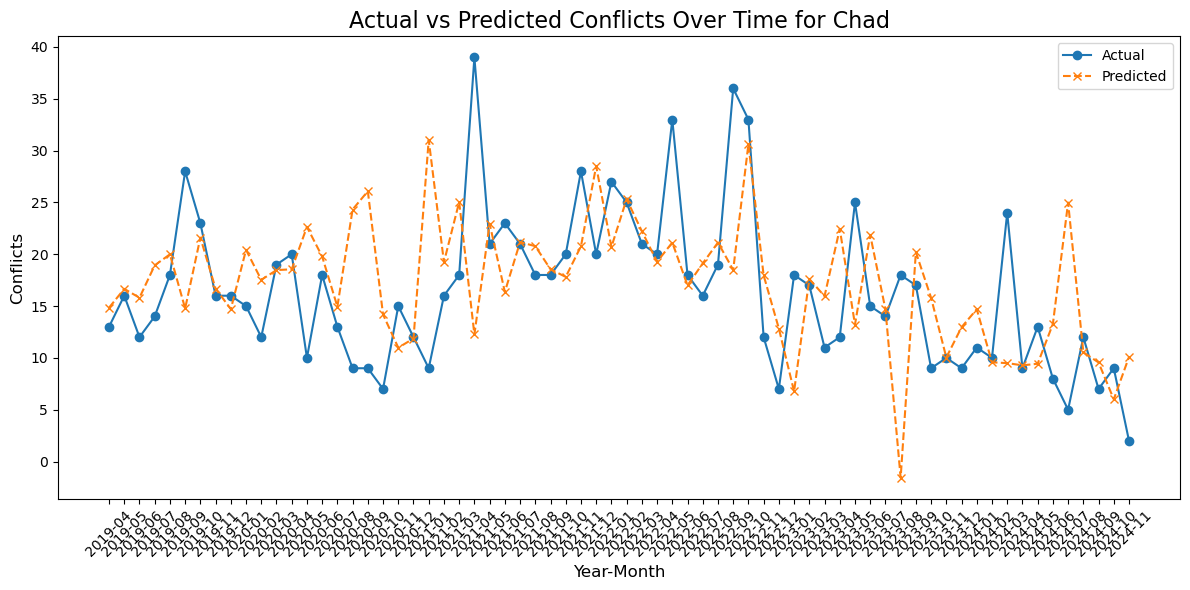

In [28]:
num_layers = 4  
single_country = 'Chad'
lag_range = 18
hidden_dim = 50


class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  
        return out
    

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)  
        out = self.fc(out[:, -1, :])  
        return out
    

country_month_conflicts = records.groupby(['country', 'year_month']).size().reset_index(name='conflicts')

sub_data = country_month_conflicts[country_month_conflicts['country'] == single_country]
sub_data = sub_data.sort_values(by='year_month')

loss_values = {}

for best_lag in range(3, lag_range):
    rnn_data = sub_data.copy()
    for lag in range(1, best_lag + 1):
        rnn_data[f'lag_{lag}'] = rnn_data['conflicts'].shift(lag)

    rnn_data = rnn_data.dropna()

    X = rnn_data[[f'lag_{lag}' for lag in range(1, best_lag + 1)]].values
    y = rnn_data['conflicts'].values

    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    y = scaler.fit_transform(y.reshape(-1, 1)).flatten()

    X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
    y = torch.tensor(y, dtype=torch.float32)

    dataset = TensorDataset(X, y)
    train_size = int(len(dataset) * 0.7)
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    model = RNNModel(input_dim=1, hidden_dim=hidden_dim, output_dim=1, num_layers=num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            loss.backward()
            optimizer.step()

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            test_loss += criterion(outputs.squeeze(), batch_y).item()


    test_loss /= len(test_loader)
    loss_values[best_lag] = test_loss

plt.figure(figsize=(10, 6))
plt.plot(list(loss_values.keys()), list(loss_values.values()), marker='o', linestyle='-')
plt.title("Test Loss for Different Lag Values", fontsize=16)
plt.xlabel("Number of Lags", fontsize=12)
plt.ylabel("Test Loss (MSE)", fontsize=12)
plt.xticks(range(3, lag_range))
plt.tight_layout()
plt.show()


best_lag = min(loss_values, key=loss_values.get)
print(f"Best Lag Value: {best_lag} with Loss: {loss_values[best_lag]}")


rnn_data = sub_data.copy()
for lag in range(1, best_lag + 1):
    rnn_data[f'lag_{lag}'] = rnn_data['conflicts'].shift(lag)


rnn_data = rnn_data.dropna()

X = rnn_data[[f'lag_{lag}' for lag in range(1, best_lag + 1)]].values
y = rnn_data['conflicts'].values


scaler = MinMaxScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y.reshape(-1, 1)).flatten()

X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1) 
y = torch.tensor(y, dtype=torch.float32)


dataset = TensorDataset(X, y)
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model = RNNModel(input_dim=1, hidden_dim=hidden_dim, output_dim=1, num_layers=num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 300
for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}")

model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        predictions.extend(outputs.squeeze().tolist())
        actuals.extend(batch_y.tolist())


predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten()


predictions_vs_actual = pd.DataFrame({
    'Actual': actuals,
    'Predicted': predictions
})


lag_value = best_lag


sub_data = sub_data.copy()
sub_data = sub_data.reset_index(drop=True)
sub_data['Predicted'] = -1


feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()


y_scaled = target_scaler.fit_transform(sub_data[['conflicts']])


for i in range(lag_value * 2, len(sub_data)):
    
    current_data = sub_data.iloc[:i].copy()

    
    for lag in range(1, lag_value + 1):
        current_data[f'lag_{lag}'] = current_data['conflicts'].shift(lag)

    
    current_data = current_data.dropna()

    
    X = current_data[[f'lag_{lag}' for lag in range(1, lag_value + 1)]].values
    X_scaled = feature_scaler.fit_transform(X)

   
    X_current = torch.tensor(X_scaled[-1], dtype=torch.float32).unsqueeze(0).unsqueeze(-1)

    model.eval()
    with torch.no_grad():
        predicted_scaled = model(X_current).item()

   
    predicted_value = target_scaler.inverse_transform([[predicted_scaled]])[0][0]

    
    sub_data.at[i, 'Predicted'] = predicted_value


results = sub_data[['year_month', 'conflicts', 'Predicted']].dropna()


results['year_month'] = results['year_month'].astype(str)


plt.figure(figsize=(12, 6))
plt.plot(results['year_month'][lag_value*2:], results['conflicts'][lag_value*2:], label='Actual', marker='o', linestyle='-')
plt.plot(results['year_month'][lag_value*2:], results['Predicted'][lag_value*2:], label='Predicted', marker='x', linestyle='--')
plt.title(f"Actual vs Predicted Conflicts Over Time for {single_country}", fontsize=16)
plt.xlabel("Year-Month", fontsize=12)
plt.ylabel("Conflicts", fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [30]:
high_fatality_types = fatalities_per_sub_event_type[fatalities_per_sub_event_type['fatalities'] > 0.01]['sub_event_type']
high_fatality_types = high_fatality_types.tolist()

filtered_records = records[records['sub_event_type'].isin(high_fatality_types)]

country_month_filtered_events = (
    filtered_records.groupby(['country', 'year_month'])
    .size()
    .reset_index(name='conflicts')
)

country_month_filtered_events.head(15)

country year_month  conflicts
0   Afghanistan    2018-01       1118
1   Afghanistan    2018-02        890
2   Afghanistan    2018-03        950
3   Afghanistan    2018-04       1205
4   Afghanistan    2018-05       1458
5   Afghanistan    2018-06       1351
6   Afghanistan    2018-07       1507
7   Afghanistan    2018-08       1337
8   Afghanistan    2018-09       1002
9   Afghanistan    2018-10       1004
10  Afghanistan    2018-11        967
11  Afghanistan    2018-12        993
12  Afghanistan    2019-01        930
13  Afghanistan    2019-02        770
14  Afghanistan    2019-03        910

/opt/anaconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


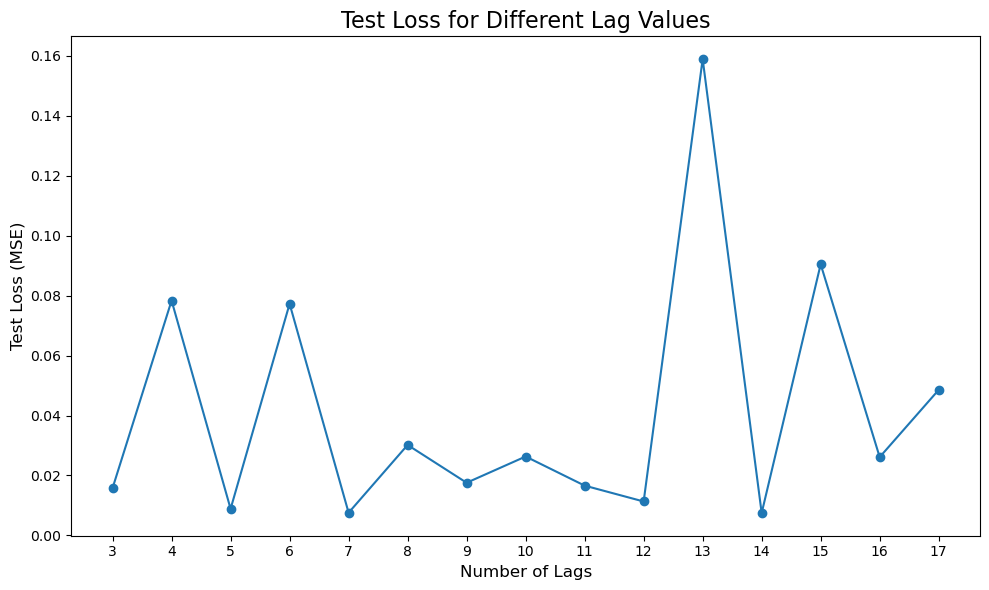

Best Lag Value: 14 with Loss: 0.007467272807843983
Epoch 20/300, Loss: 0.016859250143170357
Epoch 40/300, Loss: 0.015087409876286983
Epoch 60/300, Loss: 0.01381281390786171
Epoch 80/300, Loss: 0.01403703261166811
Epoch 100/300, Loss: 0.0059165447019040585
Epoch 120/300, Loss: 0.0026504674460738897
Epoch 140/300, Loss: 0.0010930885327979922
Epoch 160/300, Loss: 0.0014432971365749836
Epoch 180/300, Loss: 0.00016860855976119637
Epoch 200/300, Loss: 0.0006389440968632698
Epoch 220/300, Loss: 0.00015353249909821898
Epoch 240/300, Loss: 0.001546500832773745
Epoch 260/300, Loss: 8.554794476367533e-05
Epoch 280/300, Loss: 0.0009058719151653349
Epoch 300/300, Loss: 0.00016007387603167444


/var/folders/s_/yf9hp5d54l9bjwvwpjcwbk200000gn/T/ipykernel_99622/1284514474.py:201: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.76463681459427' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sub_data.at[i, 'Predicted'] = predicted_value


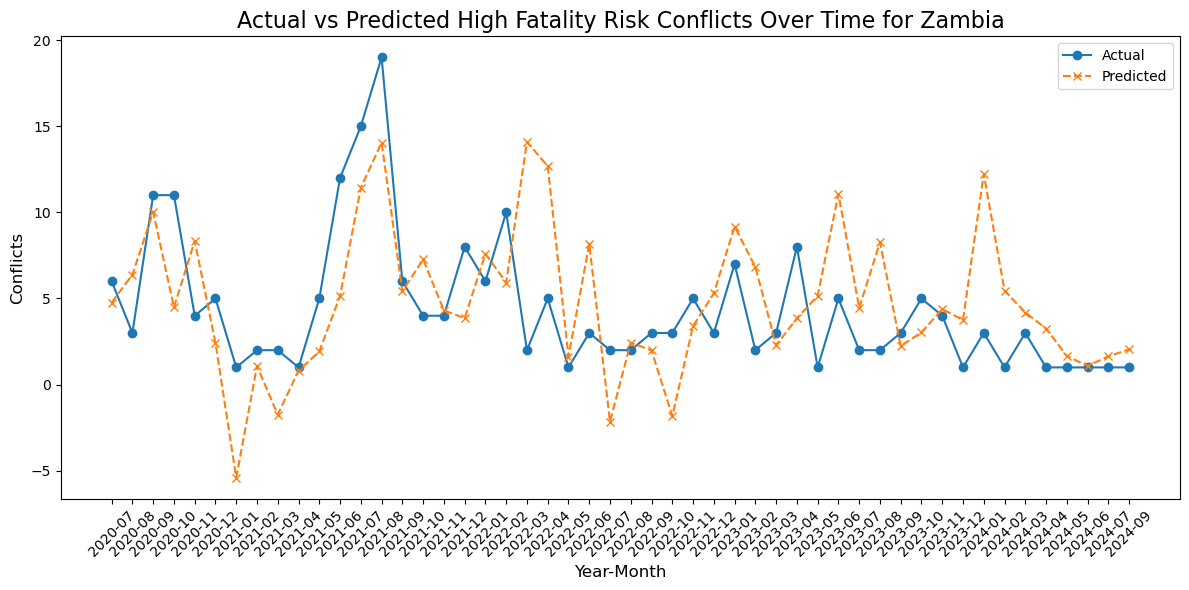

In [39]:
num_layers = 4  
single_country = 'Zambia'
lag_range = 18
hidden_dim = 50

class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  #
        return out
    

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)  
        out = self.fc(out[:, -1, :])  
        return out
    

sub_data = country_month_filtered_events[country_month_filtered_events['country'] == single_country]
sub_data = sub_data.sort_values(by='year_month')


loss_values = {}


for best_lag in range(3, lag_range):
    rnn_data = sub_data.copy()
    for lag in range(1, best_lag + 1):
        rnn_data[f'lag_{lag}'] = rnn_data['conflicts'].shift(lag)

    rnn_data = rnn_data.dropna()

    X = rnn_data[[f'lag_{lag}' for lag in range(1, best_lag + 1)]].values
    y = rnn_data['conflicts'].values


    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    y = scaler.fit_transform(y.reshape(-1, 1)).flatten()


    X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  
    y = torch.tensor(y, dtype=torch.float32)

    dataset = TensorDataset(X, y)
    train_size = int(len(dataset) * 0.7)
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    model = RNNModel(input_dim=1, hidden_dim=hidden_dim, output_dim=1, num_layers=num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            loss.backward()
            optimizer.step()

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            test_loss += criterion(outputs.squeeze(), batch_y).item()


    test_loss /= len(test_loader)
    loss_values[best_lag] = test_loss

plt.figure(figsize=(10, 6))
plt.plot(list(loss_values.keys()), list(loss_values.values()), marker='o', linestyle='-')
plt.title("Test Loss for Different Lag Values", fontsize=16)
plt.xlabel("Number of Lags", fontsize=12)
plt.ylabel("Test Loss (MSE)", fontsize=12)
plt.xticks(range(3, lag_range))
plt.tight_layout()
plt.show()


best_lag = min(loss_values, key=loss_values.get)
print(f"Best Lag Value: {best_lag} with Loss: {loss_values[best_lag]}")


rnn_data = sub_data.copy()
for lag in range(1, best_lag + 1):
    rnn_data[f'lag_{lag}'] = rnn_data['conflicts'].shift(lag)

rnn_data = rnn_data.dropna()


X = rnn_data[[f'lag_{lag}' for lag in range(1, best_lag + 1)]].values
y = rnn_data['conflicts'].values


scaler = MinMaxScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y.reshape(-1, 1)).flatten()


X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  
y = torch.tensor(y, dtype=torch.float32)


dataset = TensorDataset(X, y)
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


model = RNNModel(input_dim=1, hidden_dim=hidden_dim, output_dim=1, num_layers=num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


num_epochs = 300
for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}")

model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        predictions.extend(outputs.squeeze().tolist())
        actuals.extend(batch_y.tolist())


predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten()


predictions_vs_actual = pd.DataFrame({
    'Actual': actuals,
    'Predicted': predictions
})

lag_value = best_lag


sub_data = sub_data.copy()
sub_data = sub_data.reset_index(drop=True)
sub_data['Predicted'] = -1  

feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

y_scaled = target_scaler.fit_transform(sub_data[['conflicts']])


for i in range(lag_value * 2, len(sub_data)):

    current_data = sub_data.iloc[:i].copy()


    for lag in range(1, lag_value + 1):
        current_data[f'lag_{lag}'] = current_data['conflicts'].shift(lag)

    current_data = current_data.dropna()

    X = current_data[[f'lag_{lag}' for lag in range(1, lag_value + 1)]].values
    X_scaled = feature_scaler.fit_transform(X)

    X_current = torch.tensor(X_scaled[-1], dtype=torch.float32).unsqueeze(0).unsqueeze(-1)

    model.eval()
    with torch.no_grad():
        predicted_scaled = model(X_current).item()

    predicted_value = target_scaler.inverse_transform([[predicted_scaled]])[0][0]

    sub_data.at[i, 'Predicted'] = predicted_value

results = sub_data[['year_month', 'conflicts', 'Predicted']].dropna()


results['year_month'] = results['year_month'].astype(str)


plt.figure(figsize=(12, 6))
plt.plot(results['year_month'][lag_value*2:], results['conflicts'][lag_value*2:], label='Actual', marker='o', linestyle='-')
plt.plot(results['year_month'][lag_value*2:], results['Predicted'][lag_value*2:], label='Predicted', marker='x', linestyle='--')
plt.title(f"Actual vs Predicted High Fatality Risk Conflicts Over Time for {single_country}", fontsize=16)
plt.xlabel("Year-Month", fontsize=12)
plt.ylabel("Conflicts", fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [32]:
country_month_fatalities = records.groupby(['country', 'year_month'])['fatalities'].sum().reset_index()
country_month_fatalities

country year_month  fatalities
0      Afghanistan    2018-01        2822
1      Afghanistan    2018-02        1829
2      Afghanistan    2018-03        2286
3      Afghanistan    2018-04        2794
4      Afghanistan    2018-05        4264
...            ...        ...         ...
13444     eSwatini    2024-05           3
13445     eSwatini    2024-06           0
13446     eSwatini    2024-07           0
13447     eSwatini    2024-09           2
13448     eSwatini    2024-10           1

[13449 rows x 3 columns]

/var/folders/s_/yf9hp5d54l9bjwvwpjcwbk200000gn/T/ipykernel_99622/1312827762.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  records['year_month'] = pd.to_datetime(records['event_date']).dt.to_period('M')


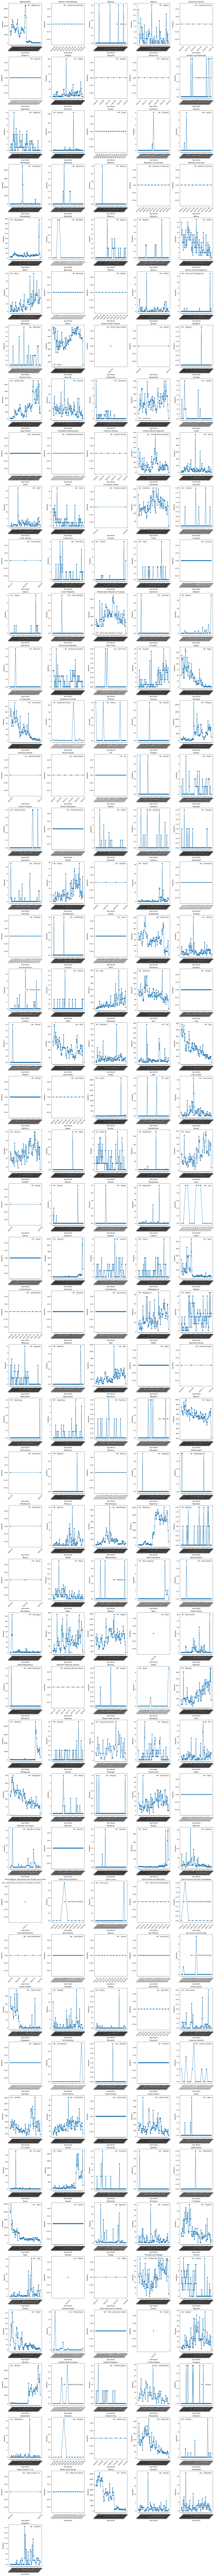

In [33]:
records['year_month'] = pd.to_datetime(records['event_date']).dt.to_period('M')
country_month_fatalities = records.groupby(['country', 'year_month'])['fatalities'].sum().reset_index()
countries = country_month_fatalities['country'].unique()

num_countries = len(countries)
cols = 5
rows = math.ceil(num_countries / cols)

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 5), constrained_layout=True)
axes = axes.flatten()

for i, country in enumerate(countries):
    ax = axes[i]
    country_data = country_month_fatalities[country_month_fatalities['country'] == country]
    ax.plot(country_data['year_month'].astype(str), country_data['fatalities'], marker='o', linestyle='-', label=country)
    ax.set_title(country)
    ax.set_xlabel('Year-Month')
    ax.set_ylabel('Fatalities')
    ax.tick_params(axis='x', rotation=45)
    ax.legend()

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.show()